# Let's try some learnning models

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Some explain of data fields
App-application name<br><br>
Category-general category of the app<br><br>
Rating-star rate(from 0 to 5)<br><br>
Reviews-number of Reviews<br><br>
Size-the size of the app in mb<br><br>
Installs-number of install(approximately)<br><br>
Type-is the app in free or not(paid)<br><br>
Price-the price in of the app<br><br>
Content Rating-Target Audience<br><br>
Genres-spesific genre(category) of the app<br><br>
Last Updated-date of the last update<br><br>
Current Ver-current version of the app<br><br>
Android Ver-minmum android version that the app support<br><br>

# Prepare the Data
I will change the rating to numeric by set 1 for rating 3.5 and up(as a success app) and 0 for the rest(as a fail app)

In [21]:
SUCCESS_RATE = 4.5
MIN_REVIEWS_NUMBER = 1000
NUM_INSTALL_TO_SUCCESS_STATE = 1000000
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [22]:
df.Installs = df.Installs.str.replace(",", "")
df.Installs = df.Installs.str.replace("+", "")
df = df[df["Installs"]!='Free']
df["Installs"] = pd.to_numeric(df["Installs"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null object
Size              10840 non-null object
Installs          10840 non-null int64
Type              10839 non-null object
Price             10840 non-null object
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.2+ MB


In [23]:
milions = df[df['Size'].str.contains('M')]
ks = df[df['Size'].str.contains('k')]
other = df[((df['Size'].str.contains('k'))|df['Size'].str.contains('M'))==False]
milions.Size = df.Size.str.replace("M", "")
milions["Size"] = pd.to_numeric(milions["Installs"])
ks["Size"] = pd.to_numeric(ks["Installs"])
df = pd.concat([milions,ks])
other['Size'] = df['Size'].median()
df = pd.concat([other,df])
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,100000.0,5000000,Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,100000.0,10000000,Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,100000.0,1000000,Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,100000.0,5000000,Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,100000.0,100000,Free,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10763,FP Разбитый дисплей,FAMILY,4.5,922,50000.0,50000,Free,0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up
10764,FP Transportation,AUTO_AND_VEHICLES,NaN,1,1.0,1,Free,0,Everyone,Auto & Vehicles,"March 9, 2018",10.0.0,4.0 and up
10798,Word Search Tab 1 FR,FAMILY,NaN,0,50.0,50,Paid,$1.04,Everyone,Puzzle,"February 6, 2012",1.1,3.0 and up
10832,FR Tides,WEATHER,3.8,1195,100000.0,100000,Free,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up


In [24]:
df = df.dropna(axis=0, subset=['Type'])#delete one row
df.isna().sum()

App                  0
Category             0
Rating            1473
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [25]:
print(df['Type'].unique())
df.loc[df['Type']=='Free','Type']=0
df.loc[df['Type']=='Paid','Type']=1

['Free' 'Paid']


In [26]:
df.Category = pd.Categorical(df.Category)
df['Category_code'] = df.Category.cat.codes

In [27]:
#need to change tthis to more clusters
df['success'] = 0
df.loc[df['Installs']>NUM_INSTALL_TO_SUCCESS_STATE,'success']=1
df.loc[df['Installs']<NUM_INSTALL_TO_SUCCESS_STATE,'success']=0
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Category_code,success
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,100000.0,5000000,0,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up,0,1
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,100000.0,10000000,0,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device,0,1
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,100000.0,1000000,0,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,1,0
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,100000.0,5000000,0,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,1,1
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,100000.0,100000,0,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10763,FP Разбитый дисплей,FAMILY,4.5,922,50000.0,50000,0,0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up,11,0
10764,FP Transportation,AUTO_AND_VEHICLES,NaN,1,1.0,1,0,0,Everyone,Auto & Vehicles,"March 9, 2018",10.0.0,4.0 and up,1,0
10798,Word Search Tab 1 FR,FAMILY,NaN,0,50.0,50,1,$1.04,Everyone,Puzzle,"February 6, 2012",1.1,3.0 and up,11,0
10832,FR Tides,WEATHER,3.8,1195,100000.0,100000,0,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up,32,0


In [28]:
print(df['Content Rating'].unique())
df['Content Rating'] = pd.Categorical(df['Content Rating'])
df['Content Rating'] = df['Content Rating'].cat.codes

['Everyone' 'Teen' 'Mature 17+' 'Everyone 10+' 'Adults only 18+' 'Unrated']


# Run All Classification Models

In [29]:
X = df[['Size','Type','Category_code','Content Rating']]
y = df['success']

## k-Nearest Neighbors

Text(0, 0.5, 'Cross-Validated Accuracy')

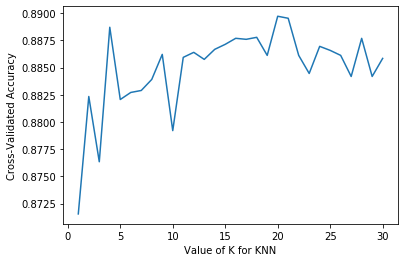

In [31]:
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Decision tree

## Logistic regression

## Neural network